In [4]:
import pandas as pd
filename = 'generic_ratios_by_chemical_4.csv'
try:
    df = pd.read_csv(filename)
except IOError:
    sql = """WITH
      num AS (
      SELECT
        month,
        SUBSTR(bnf_code, 0, 9) AS product,
        SUM(items) AS items
      FROM
        `ebmdatalab.hscic.normalised_prescribing_standard`
      WHERE
        bnf_code LIKE '_________AA%'
      GROUP BY
        month,
        product),
      denom AS (
      SELECT
        month,
        SUBSTR(bnf_code, 0, 9) AS product,
        SUM(items) AS items
      FROM
        `ebmdatalab.hscic.normalised_prescribing_standard`
      GROUP BY
        month,
        product),
      data AS (
      SELECT
        num.month,
        num.product,
        num.items / denom.items AS value,
        denom.items AS items
      FROM
        num
      INNER JOIN
        denom
      ON
        num.month = denom.month
        AND num.product = denom.product ),
      data_with_stats AS (
      SELECT
        DISTINCT month,
        product,
        value,
        data.items AS total_items,
        LAST_VALUE(value) OVER (PARTITION BY product ORDER BY month ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) - FIRST_VALUE(value) OVER (PARTITION BY product ORDER BY month ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS delta,
        ABS(PERCENTILE_CONT(value,
            0.75) OVER (PARTITION BY product) - PERCENTILE_CONT(value,
            0.25) OVER (PARTITION BY product)) AS iqr
      FROM
        data )
    SELECT
      bnf.chemical AS product_name,
      data_with_stats.*
    FROM
      data_with_stats
    INNER JOIN 
      (SELECT DISTINCT chemical, chemical_code FROM `ebmdatalab.hscic.bnf`) bnf 
    ON
      bnf.chemical_code = data_with_stats.product
      """
    df = pd.read_gbq(sql, 'ebmdatalab', verbose=False, dialect='standard')
    df.to_csv(filename)

/home/seb/.local/share/virtualenvs/jupyter/local/lib/python3.6/site-packages/pandas/io/gbq.py:108: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  **kwargs)


In [5]:
sql = """WITH
  num AS (
  SELECT
    month,
    SUM(items) AS items,
    SUM(actual_cost) AS actual_cost
  FROM
    `ebmdatalab.hscic.normalised_prescribing_standard`
  WHERE
    bnf_code LIKE '_________AA%'
  GROUP BY
    month),
  denom AS (
  SELECT
    month,
    SUM(items) AS items,
    SUM(actual_cost) AS actual_cost
  FROM
    `ebmdatalab.hscic.normalised_prescribing_standard`
  --WHERE
  --  bnf_code LIKE '0%'
  GROUP BY
    month)
SELECT
  num.month,
  num.items / denom.items AS items_percent,
  num.actual_cost / denom.actual_cost AS act_cost_percent
FROM
  num
INNER JOIN
  denom
ON
  num.month = denom.month"""
top_df = pd.read_gbq(sql, 'ebmdatalab', verbose=False, dialect='standard')

/home/seb/.local/share/virtualenvs/jupyter/local/lib/python3.6/site-packages/pandas/io/gbq.py:108: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  **kwargs)


# Overall generic prescribing

The following chart shows that the proportion of prescriptions made generically has not dropped over the last 8 years; the proportion of spending which has been prescribed generically has dropped a lot more.



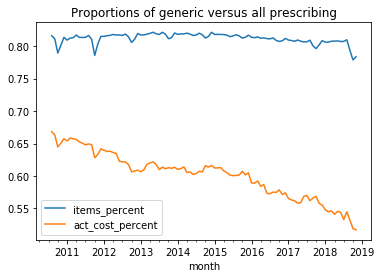

In [8]:
top_df = top_df.sort_values('month')
top_df.set_index('month').plot.line(title="Proportions of generic versus all prescribing")

# Which are the chemicals showing the greatest positive and negative changes?

In [26]:
most_variance = df.groupby('product').min().reset_index()
most_variance = most_variance[most_variance.total_items > 10000].sort_values('iqr', ascending=False).head(50)

In [27]:
most_variance

,product,product_name,month,value,total_items,delta,iqr
1933,1404000L0,Pneumococcal,2010-08-01,0.000174,14903,0.996960,0.985695
1716,1302011M0,Liquid Paraffin,2010-08-01,0.017774,13278,-0.580362,0.463628
712,0411000F0,Galantamine,2010-08-01,0.365902,13849,-0.557149,0.453641
1714,130201100,Emollient Bath & Shower Preparations,2010-08-01,0.271655,79653,-0.495990,0.355600
659,0408010Q0,Phenytoin Sodium,2010-08-01,0.645750,55969,0.351176,0.342271
362,0302000K0,Budesonide,2010-08-01,0.143771,257502,-0.379180,0.275971
642,0408010AE,Pregabalin,2010-08-01,0.546930,140772,-0.017969,0.275875
1556,1106000AD,Latanoprost & Timolol,2010-08-01,0.500683,23484,0.381675,0.263378
602,0407020AD,Oxycodone Hydrochloride,2010-08-01,0.308518,72685,-0.313963,0.246140
600,0407020A0,Fentanyl,2010-08-01,0.204811,77476,-0.478421,0.245871


# Chemicals being prescribed more and more as generics

/home/seb/.local/share/virtualenvs/jupyter/local/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


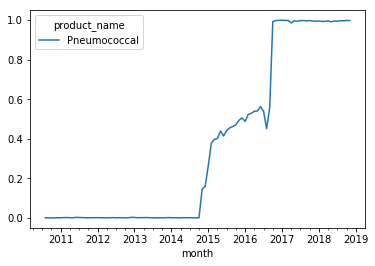

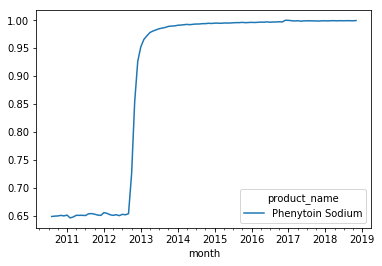

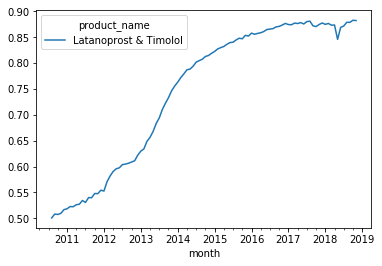

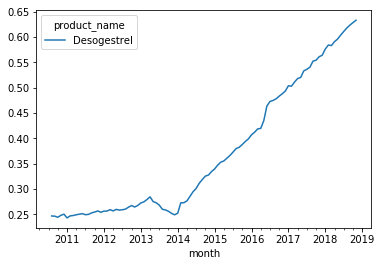

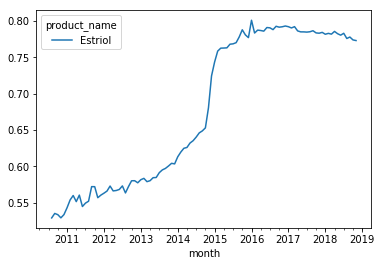

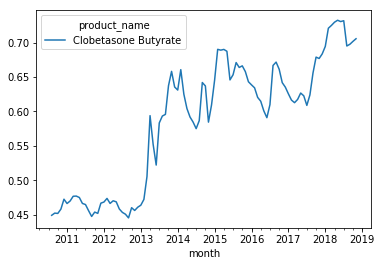

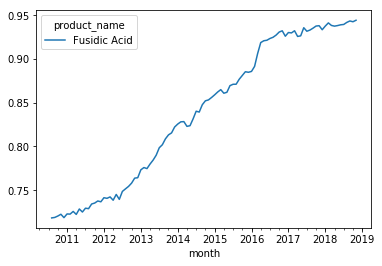

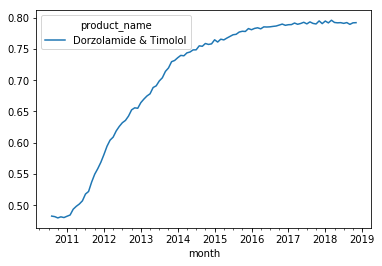

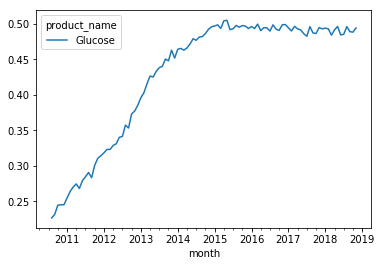

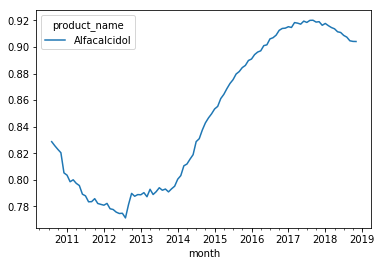

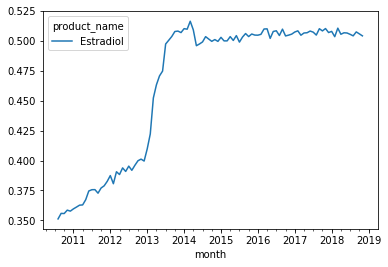

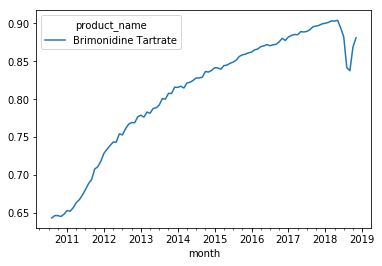

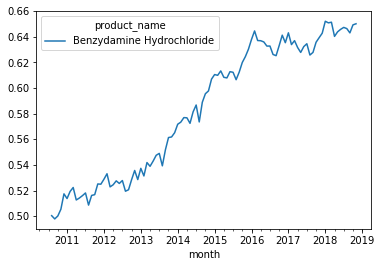

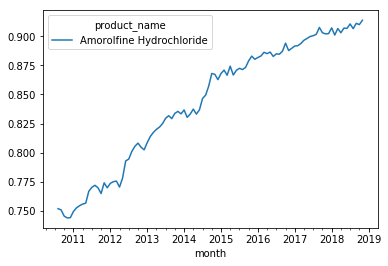

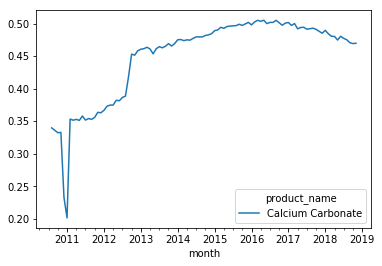

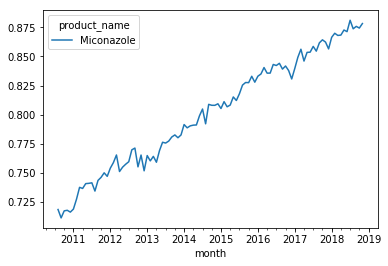

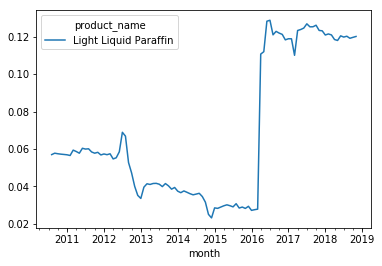

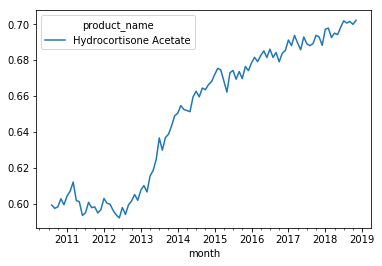

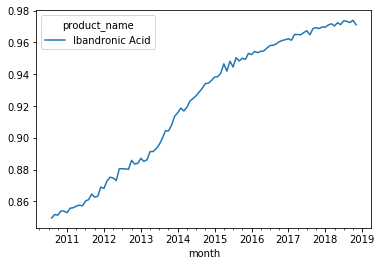

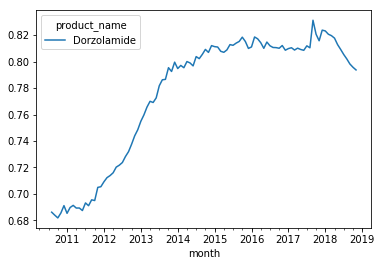

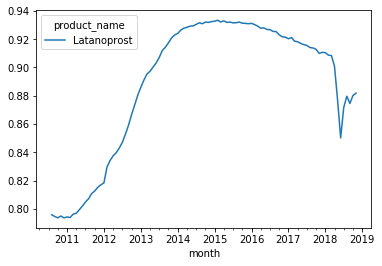

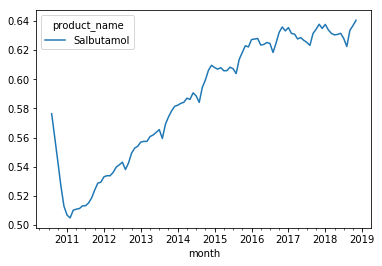

In [28]:
%matplotlib inline
for product in most_variance[most_variance['delta'] > 0]['product']:
    df[df['product'] == product].groupby(['month', 'product_name']).sum().value.unstack().plot.line()


# Chemicals being prescribed less and less as generics


/home/seb/.local/share/virtualenvs/jupyter/local/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


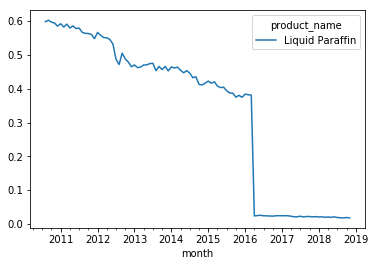

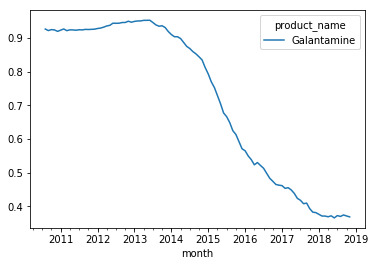

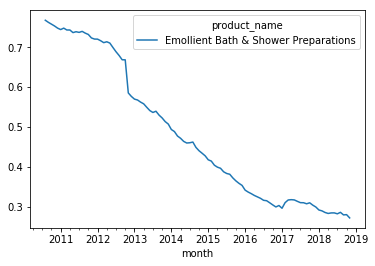

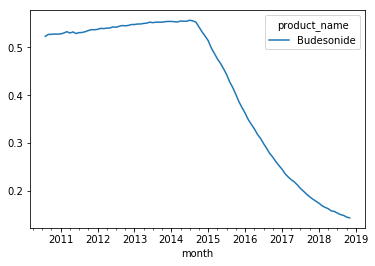

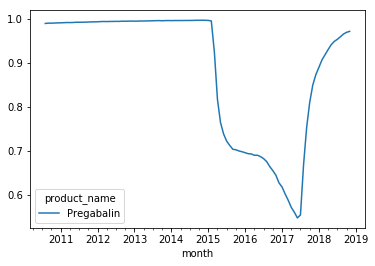

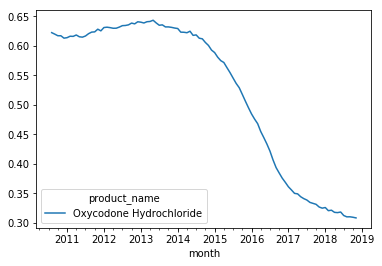

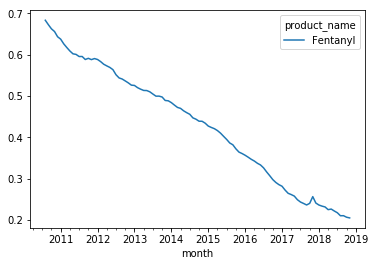

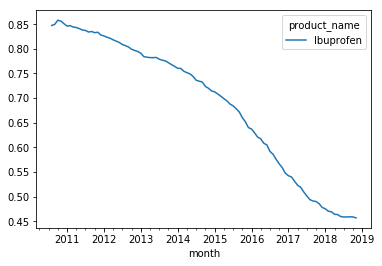

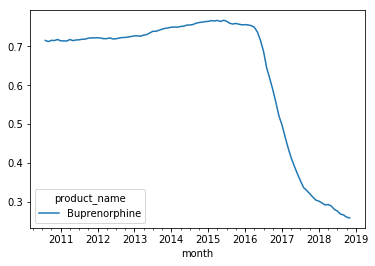

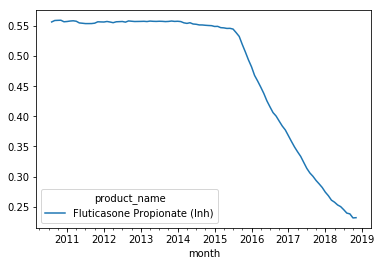

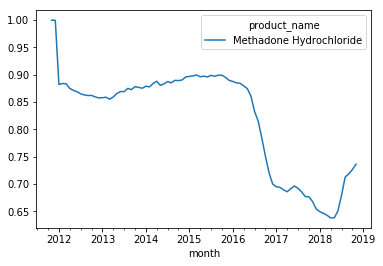

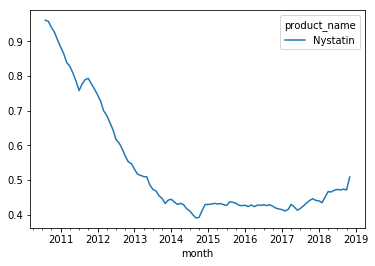

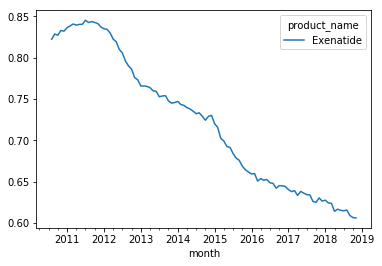

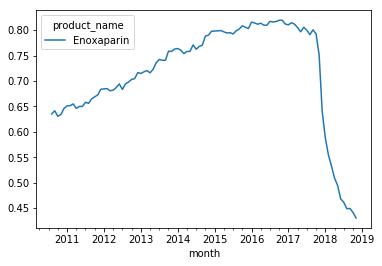

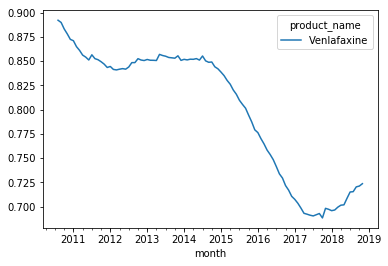

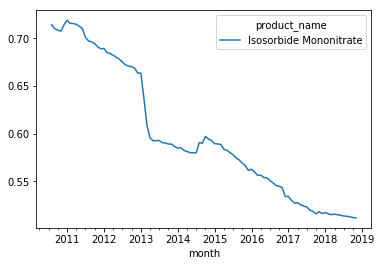

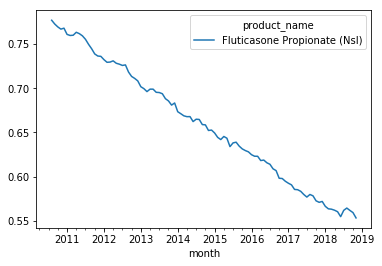

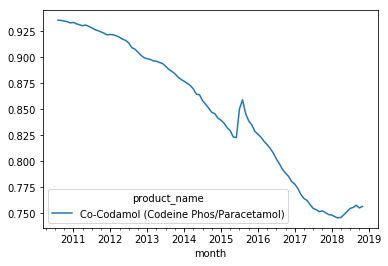

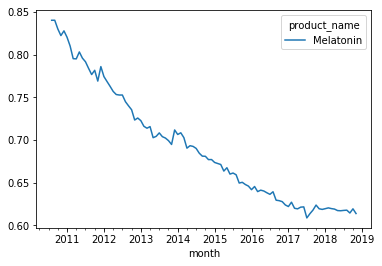

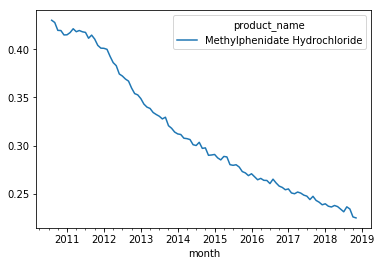

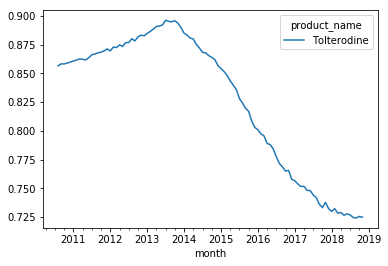

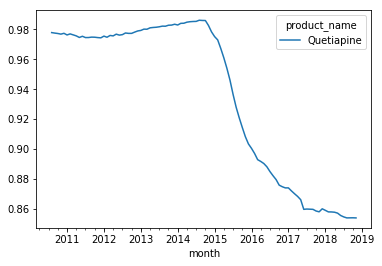

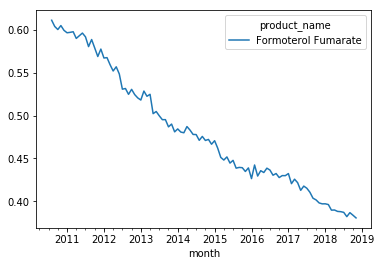

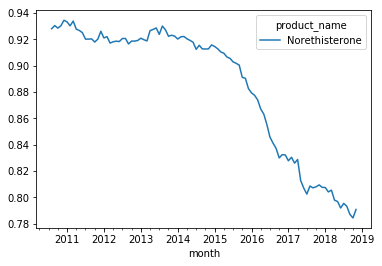

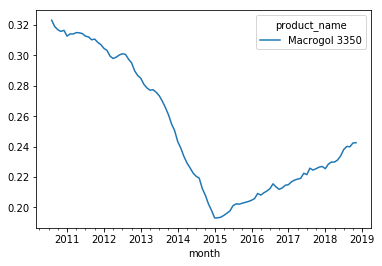

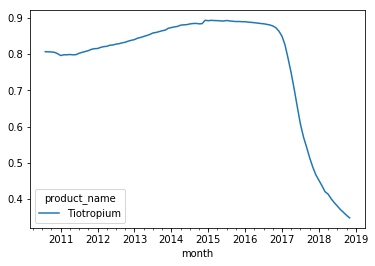

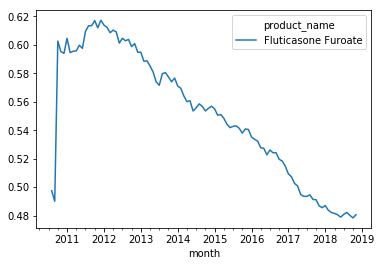

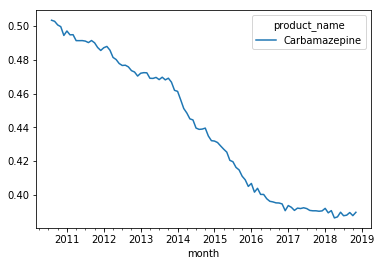

In [29]:
%matplotlib inline
for product in most_variance[most_variance['delta'] < 0]['product']:
    df[df['product'] == product].groupby(['month', 'product_name']).sum().value.unstack().plot.line()
